In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from kernel import KernelComputer, KernelRegressor
from dataloader import Synthesizer

In [2]:
%matplotlib inline
np.random.seed(0)

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [3]:
n_train = 30
n_test = 200
exp_par, offset = 3, .5
corruption = exp_par, offset

datagen = Synthesizer('IR-' + str(n_train))
x_train, y_train = datagen.get_trainset()
x_test, y_test = datagen.get_testset(n_test)
S_train = datagen.synthetic_corruption(y_train, corruption)
c_train, r_train = S_train

In [4]:
exp_par, offset = corruption
r_train = abs(offset) - np.log(np.random.rand(n_train)) / exp_par
mu = (2 * np.random.rand(n_train) - 1) * r_train
c_train = y_train + np.abs(mu)[:, np.newaxis] * np.sign(y_train)

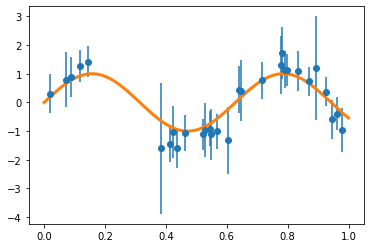

In [5]:
fig, ax = plt.subplots()
a = ax.errorbar(x_train.squeeze(), c_train.squeeze(), yerr=r_train, fmt='o', color="C0")
b, = ax.plot(x_test.squeeze(), y_test.squeeze(), linestyle="-", linewidth=3, color="C1")

In [6]:
def l2_loss(A, B):
    dist = A @ B.T
    dist *= -2
    dist += np.sum(A ** 2, axis=1)[:, np.newaxis]
    dist += np.sum(B ** 2, axis=1)
    return dist


def point_l2_loss(a, b):
    dist = a - b
    dist **= 2
    dist = np.sum(dist, axis=1)
    return dist

In [7]:
y_grid = np.linspace(-3, 3, num=1000)[:, np.newaxis]
AC_loss = l2_loss(c_train, y_grid)
IL_loss = np.sqrt(AC_loss)
IL_loss -= r_train[:, np.newaxis]
IL_loss[IL_loss < 0] = 0
IL_loss **= 2

In [8]:
kernel = KernelComputer('Laplacian', sigma=1)

In [9]:
kernel_reg = KernelRegressor(kernel)
kernel_reg.set_support(x_train)

sigmas = [1e0, 5e-1, 1e-1, 5e-2, 1e-2]
lambdas = [1e3, 1e0, 1e-3]

best_err_ac, best_err_il = np.inf, np.inf
best_s_ac, best_s_il = None, None
best_l_ac, best_l_il = None, None

for sigma in sigmas:
    kernel_reg.update_sigma(sigma)
    for lambd in lambdas:
        kernel_reg.update_lambda(lambd)
        alpha = kernel_reg(x_test)
        
        loss_grid = alpha @ AC_loss
        y_ac = y_grid[np.argmin(loss_grid, axis=1)]

        loss_grid = alpha @ IL_loss
        y_il = y_grid[np.argmin(loss_grid, axis=1)]
        
        err_ac = np.diag(l2_loss(y_ac, y_test)).mean()
        err_il = np.diag(l2_loss(y_il, y_test)).mean()
        
        if err_ac < best_err_ac:
            best_err_ac = err_ac
            best_s_ac = sigma
            best_l_ac = lambd
            best_y_ac = y_ac
            
        if err_il < best_err_il:
            best_err_il = err_il
            best_s_il = sigma
            best_l_il = lambd
            best_y_il = y_il

In [10]:
best_err_il, best_err_ac, best_s_il, best_s_ac, best_l_il, best_l_ac

(0.05037980491885885, 0.12936766530466873, 1.0, 1.0, 0.001, 0.001)

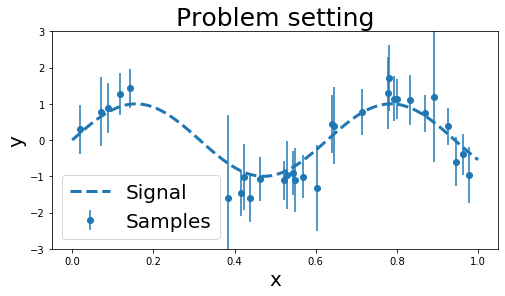

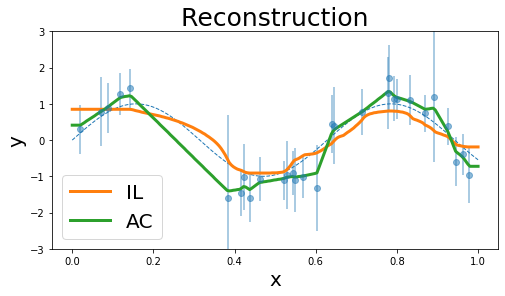

In [11]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
a = ax1.errorbar(x_train.squeeze(), c_train.squeeze(), yerr=r_train, fmt='o', color="C0")
b, = ax1.plot(x_test.squeeze(), y_test.squeeze(), linestyle="--", linewidth=3, color="C0")
ax1.legend([b, a], ["Signal", "Samples"], prop={"size": 20})
ax1.set_title("Problem setting", size=25)
ax1.set_xlabel("x", size=20)
ax1.set_ylabel("y", size=20)
ax1.set_ylim(-3, 3)

fig2, ax2 = plt.subplots(figsize=(8, 4))
a, = ax2.plot(x_test.squeeze(), y_test.squeeze(), linestyle="--", linewidth=1, color="C0")
ax2.errorbar(x_train.squeeze(), c_train.squeeze(), yerr=r_train, fmt='o', color="C0", alpha=.5)
b, = ax2.plot(x_test.squeeze(), best_y_il.squeeze(), linestyle="-", linewidth=3, color="C1")
c, = ax2.plot(x_test.squeeze(), best_y_ac.squeeze(), linestyle="-", linewidth=3, color="C2")
ax2.legend([b, c], ['IL', 'AC'], prop={'size':20})
ax2.set_title("Reconstruction", size=25)
ax2.set_xlabel("x", size=20)
ax2.set_ylabel("y", size=20)
ax2.set_ylim(-3, 3)
fig1.savefig('setting.pdf')
fig2.savefig('reconstruction.pdf')